**Exercise 3: Corner detection**

*CPSC 480/580: Computer Vision*

*Yale University*

*Instructor: Alex Wong*

**Prerequisites**:

1. Enable Google Colaboratory as an app on your Google Drive account

2. Create a new Google Colab notebook, this will also create a "Colab Notebooks" directory under "MyDrive" i.e.
```
/content/drive/MyDrive/Colab Notebooks
```

3. Create the following directory structure in your Google Drive
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises
```

4. Move the 03_exercise.ipynb into
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises
```
so that its absolute path is
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises/03_exercise.ipynb
```

In this exercise, we will implement the Moravec corner detector and applies it onto several images, with and without noise. Experiment with Harris corner detector from scikit-image and compare it with Moravec detector.


**Submission**:

1. Implement all TODOs in the code blocks below.

2. Run the Colab Notebook to produce results for each code block.

3. List any collaborators.

```
Collaborators: Doe, Jane (Please write names in <Last Name, First Name> format)

Collaboration details: Discussed ... implementation details with Jane Doe.
```

Import packages

In [23]:
import skimage.data
import skimage.feature as feat
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt

Utility functions for plotting

In [24]:
def config_plot():
    '''
    Function to remove axis tickers and box around figure
    '''

    plt.box(False)
    plt.axis('off')

In [25]:
def extract_image_patch(image, patch_size, yx):
    '''
    Extract a patch of size k x k at (y, x) location of the image

    Arg(s):
        image : numpy[float32]
            H x W x C image
        patch_size : tuple[int]
            (k1, k2) k1 and k2 are the dimensions of the patch
        yx : numpy[float]
            [y, x] location of where to extract the patch
    Returns:
        numpy[float32] : k x k patch located at (y, x) coordinate of the image
    '''
    # EX: image_gray, patch_size, (y, x)
    # Note: not Cartesian cords but: y --> down row-wise; x --> across column wise
    k1, k2 = patch_size
    y, x = yx[0], yx[1]
    # TODO: Determine start and end to slice the array for each y-, x-direction
    # Adjusted slicing to correctly handle patch extraction based on the center yx coordinate
    y_start = y - k1 // 2
    y_end = y + (k1 // 2)
    x_start = x - k2 // 2
    x_end = x + (k2 // 2)


    # TODO: Returns a patch of size k x k at (y, x) location of the image
    return image[y_start:y_end, x_start:x_end]

In [26]:
def sum_squared_difference(src, tgt):
    '''
    Computes sum of squared difference (SSD) between two vectors

    Arg(s):
        src : numpy[float32]
            N element source vector
        tgt : numpy[float32]
            N element target vector
    Returns:
        float : sum of squared differences (SSD) between two vectors
    '''

    # TODO: Compute sum of squared differences
    return np.sum((src - tgt) ** 2).astype(np.float32)

Loading data

In [27]:
# Load checkerboard image from skimage
image_checkerboard = skimage.data.checkerboard()

# Load coins image from skimage
image_coin = skimage.data.coins()

images = [image_checkerboard, image_coin]
images_gray = [None] * len(images)
images_noisy = [None] * len(images)

# TODO: Create gray (if images aren't already) and noisy versions of them with variance of 0.005
for idx, image in enumerate(images):

    # TODO: Convert images to gray if it isn't already
    if image.ndim == 3: # not gray
        images_gray[idx] = ski.color.rgb2gray(image)
    else:
        images_gray[idx] = image

    # TODO: Add noise to simulate noisy capture for images
    images_noisy[idx] = 255.0 * skimage.util.random_noise(image, mode='gaussian', var=0.005)

# Unpack images to checkerboard and coin
image_checkerboard_gray, image_coin_gray = images_gray
image_checkerboard_noisy, image_coin_noisy = images_noisy

Moravec corner detector

In [28]:
def moravec_corner(image_gray, patch_size, threshold):
    '''
    Detects corners using Moravec corner detector

    Arg(s):
        image_gray : numpy[float32]
            H x W gray/monochrome image
        patch_size : numpy[float32]
            (h, w) tuple denoting the height and width of the patch
        threshold : float
            threshold for determining if response is a corner
    Returns:
        numpy[float32] : H x W Moravec response image
        numpy[float32] : N x 2 array of corner coordinates
    '''
    '''
    TF Pseudocode:
    1. Pick a window
    2. Look at neighbors (left, right, up, down)
    '''

    '''
    Debugging
    first call made:
    image_coin_gray_moravec, yx_coin_gray_moravec = moravec_corner(image_coin_gray, patch_size_moravec, 510)
    '''

    # note: use half-sizes so patch stays centered
    h, w = int(patch_size[0]), int(patch_size[1])
    # add +1 so ±1 shifts still keep the h×w patch fully inside the padded image
    # TODO: Pad image based on patch size
    if h % 2 == 0: h += 1
    if w % 2 == 0: w += 1

    padding_y, padding_x = h // 2, w // 2

    image_gray_padded = np.pad(
        image_gray,
        [(padding_y + 1, padding_y + 1), (padding_x + 1, padding_x + 1)], # Increased padding to handle all shifts
        mode='edge'
    )
    # Adjusted center coordinate in padded image
    base_y, base_x = padding_y + 1, padding_x + 1


    # TODO: Compute minimum dissimilarity for patches centered at each pixel
    H, W = image_gray.shape
    n_height, n_width = image_gray_padded.shape

    # same shape & dtype as input is fine; zeros_like works too
    image_moravec = np.zeros((H, W), dtype=np.float32)

    # Define shifts based on the reference solution
    shifts = [
        [1, 1],
        [0, 1],
        [1, -1],
        [1, 0]
    ]


    # loop through the whole image
    for y in range(H):
        # center cords in the padded image --> responds to (y, x) in original
        cy = base_y + y
        for x in range(W):
            cx = base_x + x

            # Extract patch at (yp, xp) in padded image
            image_gray_yx = extract_image_patch(
                image_gray_padded,
                (h, w),
                (cy, cx)
            )

            # Compute minimum dissimilarity for patches centered at each pixel
            m = np.inf
            for dy, dx in shifts:
                ny, nx = cy + dy, cx + dx
                patch = extract_image_patch(image_gray_padded, (h, w), [ny, nx])
                ssd = sum_squared_difference(image_gray_yx, patch)
                if ssd < m:
                    m = ssd

            image_moravec[y, x] = m


    # TODO: Convert Moravec response map to corner map by threshold
    # Changed condition to > threshold as higher values indicate corners
    corner_moravec = np.where(image_moravec > threshold, 1, 0)

    # TODO: Convert Moravec corner map to coordinates
    # Corrected indexing to get y and x coordinates separately
    yx_moravec = np.array(np.where(corner_moravec > 0)).T

    '''
    Conceptually: high values --> likely a corner
    - low values --> flat or edge-like region
    '''

    return image_moravec, yx_moravec

Moravec corner detector

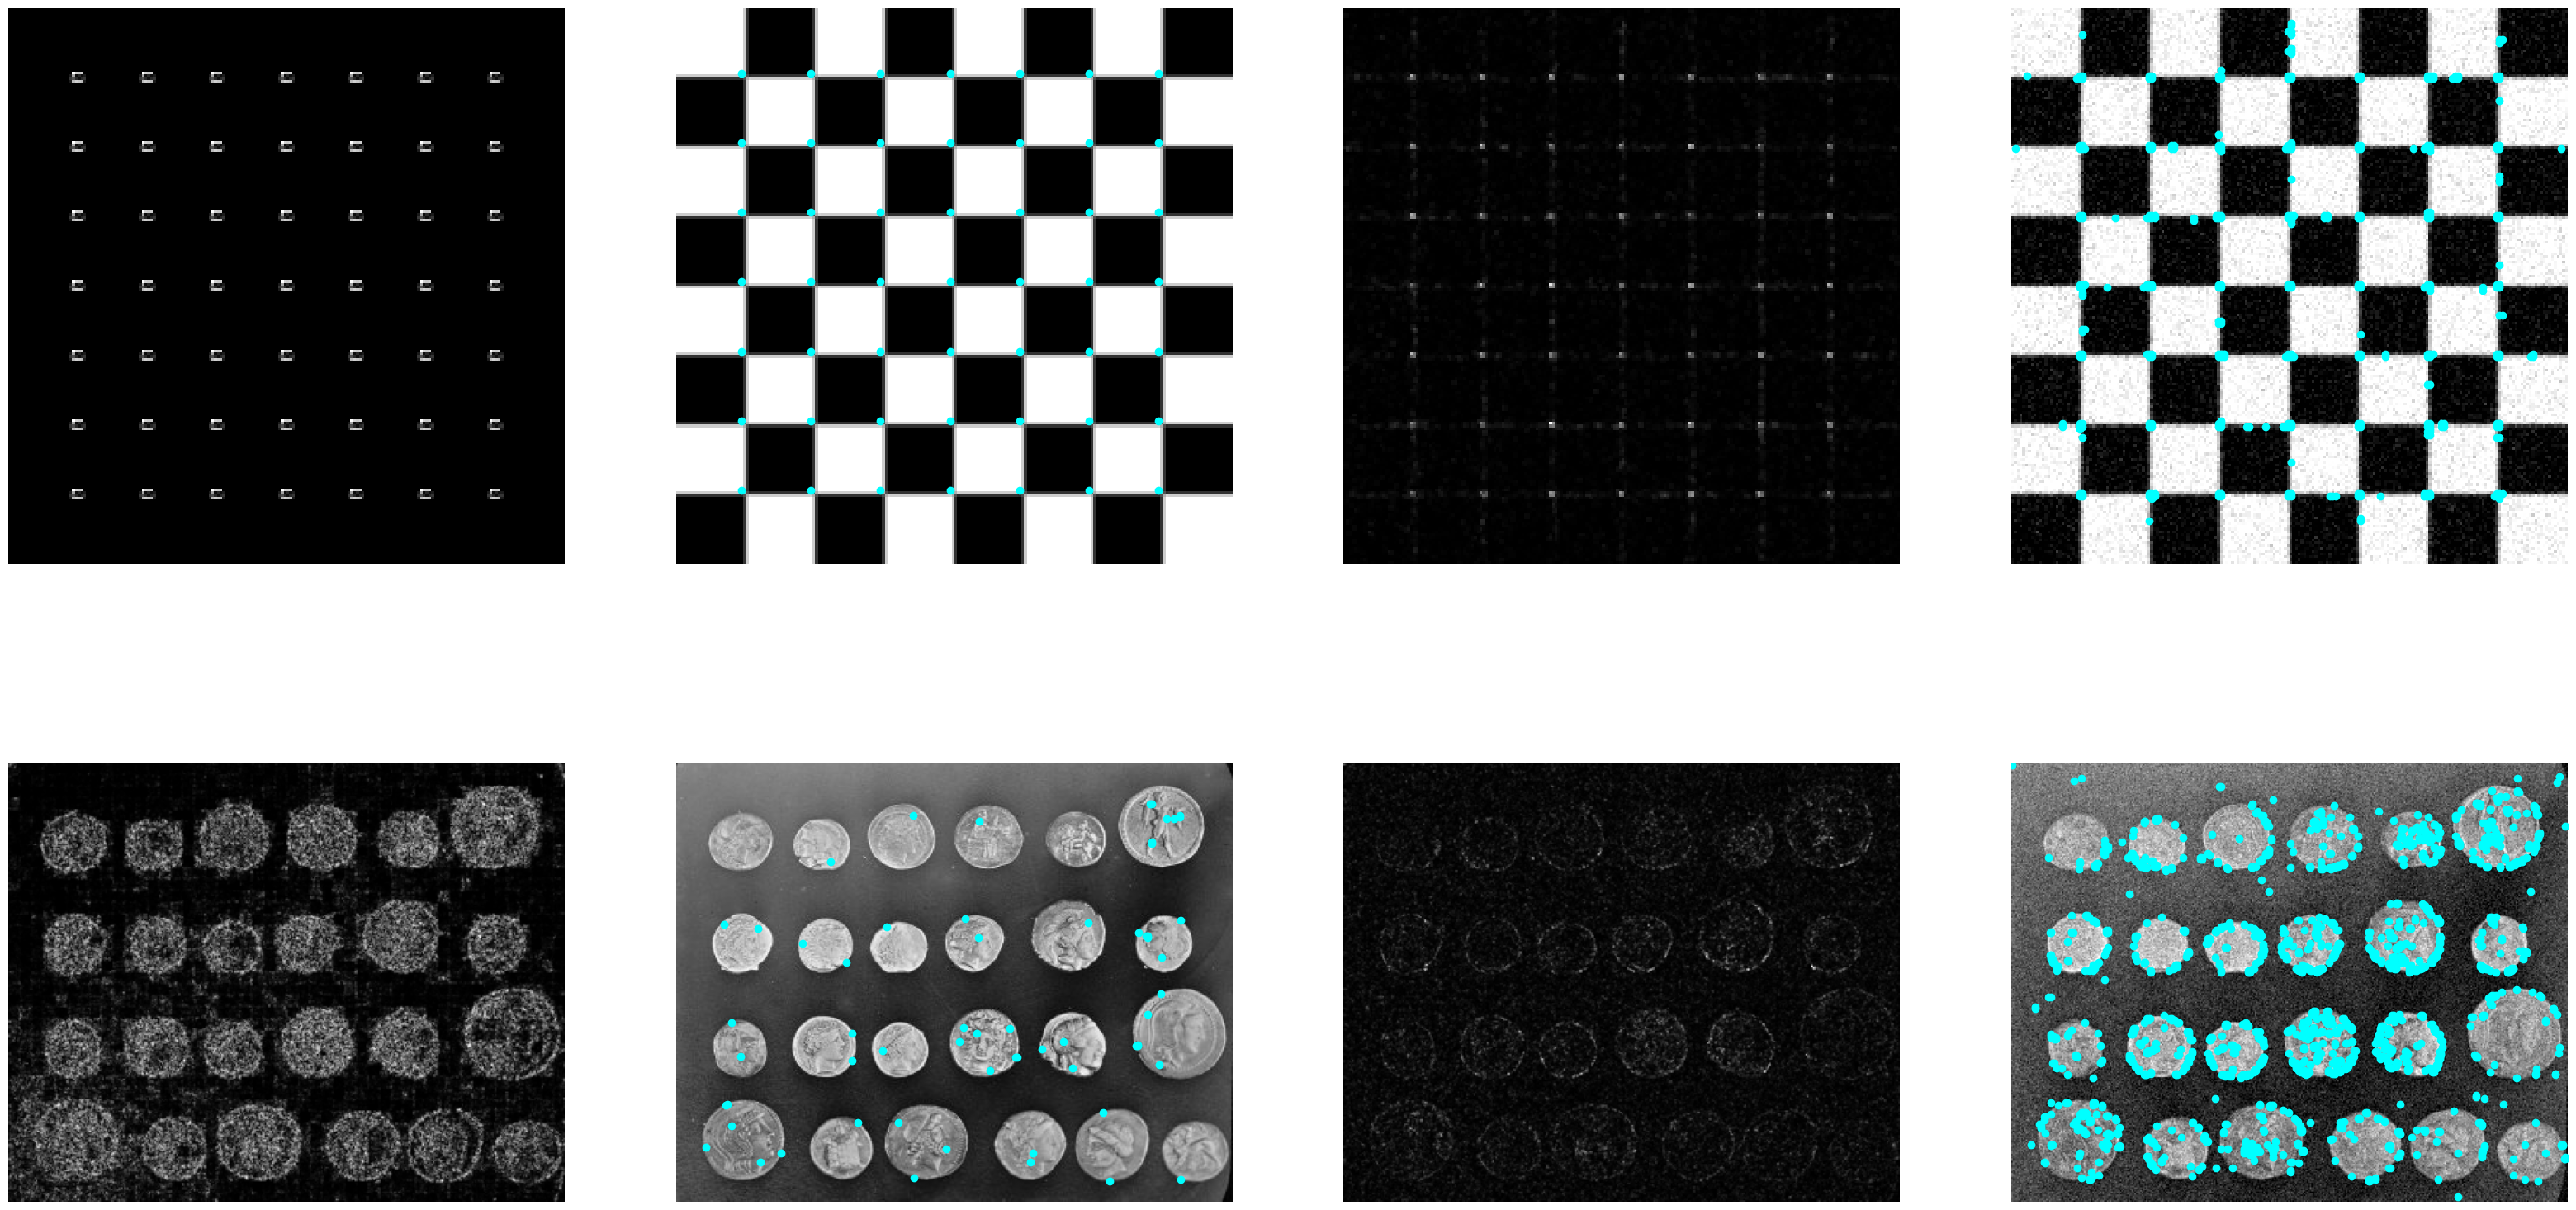

In [29]:
patch_size_moravec = [3, 3]

# TODO: Run moravec corner detector on coin image with threshold of 510
image_coin_gray_moravec, yx_coin_gray_moravec = moravec_corner(image_coin_gray, patch_size_moravec, 510)

# TODO: Run moravec corner detector on noisy coin image with threshold of 8000
image_coin_noisy_moravec, yx_coin_noisy_moravec = moravec_corner(image_coin_noisy, patch_size_moravec, 8000)

# TODO: Run moravec corner detector on checkerboard image with threshold of 300
image_checkerboard_gray_moravec, yx_checkerboard_gray_moravec = moravec_corner(image_checkerboard_gray, patch_size_moravec, 300)
# print(yx_checkerboard_gray_moravec)

# TODO: Run moravec corner detector on noisy checkerboard image with threshold of 8000
image_checkerboard_noisy_moravec, yx_checkerboard_noisy_moravec = moravec_corner(image_checkerboard_noisy, patch_size_moravec, 8000)

# Create visualization
fig = plt.figure(figsize=(40, 42))

# TODO: Plot points from Moravec corner for checkerboard
ax = fig.add_subplot(4, 4, 1)
ax.imshow(image_checkerboard_gray_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 2)
ax.imshow(image_checkerboard_gray, cmap='gray')
if yx_checkerboard_gray_moravec.size > 0:
    ys = yx_checkerboard_gray_moravec[:, 0]
    xs = yx_checkerboard_gray_moravec[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6)
config_plot()

# TODO: Plot points from Moravec corner for noisy checkerboard
ax = fig.add_subplot(4, 4, 3)
ax.imshow(image_checkerboard_noisy_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 4)
ax.imshow(image_checkerboard_noisy, cmap='gray')
if yx_checkerboard_noisy_moravec.size > 0:
    ys = yx_checkerboard_noisy_moravec[:, 0]
    xs = yx_checkerboard_noisy_moravec[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6)
config_plot()

# TODO: Plot points from Moravec corner for coin
ax = fig.add_subplot(4, 4, 5)
ax.imshow(image_coin_gray_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 6)
ax.imshow(image_coin_gray, cmap='gray')
if yx_coin_gray_moravec.size > 0:
    ys = yx_coin_gray_moravec[:, 0]
    xs = yx_coin_gray_moravec[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6)
config_plot()

# TODO: Plot points from Moravec corner for noisy coin
ax = fig.add_subplot(4, 4, 7)
ax.imshow(image_coin_noisy_moravec, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 8)
ax.imshow(image_coin_noisy, cmap='gray')
if yx_coin_noisy_moravec.size > 0:
    ys = yx_coin_noisy_moravec[:, 0]
    xs = yx_coin_noisy_moravec[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6)
config_plot()

plt.show()

Harris corner detector

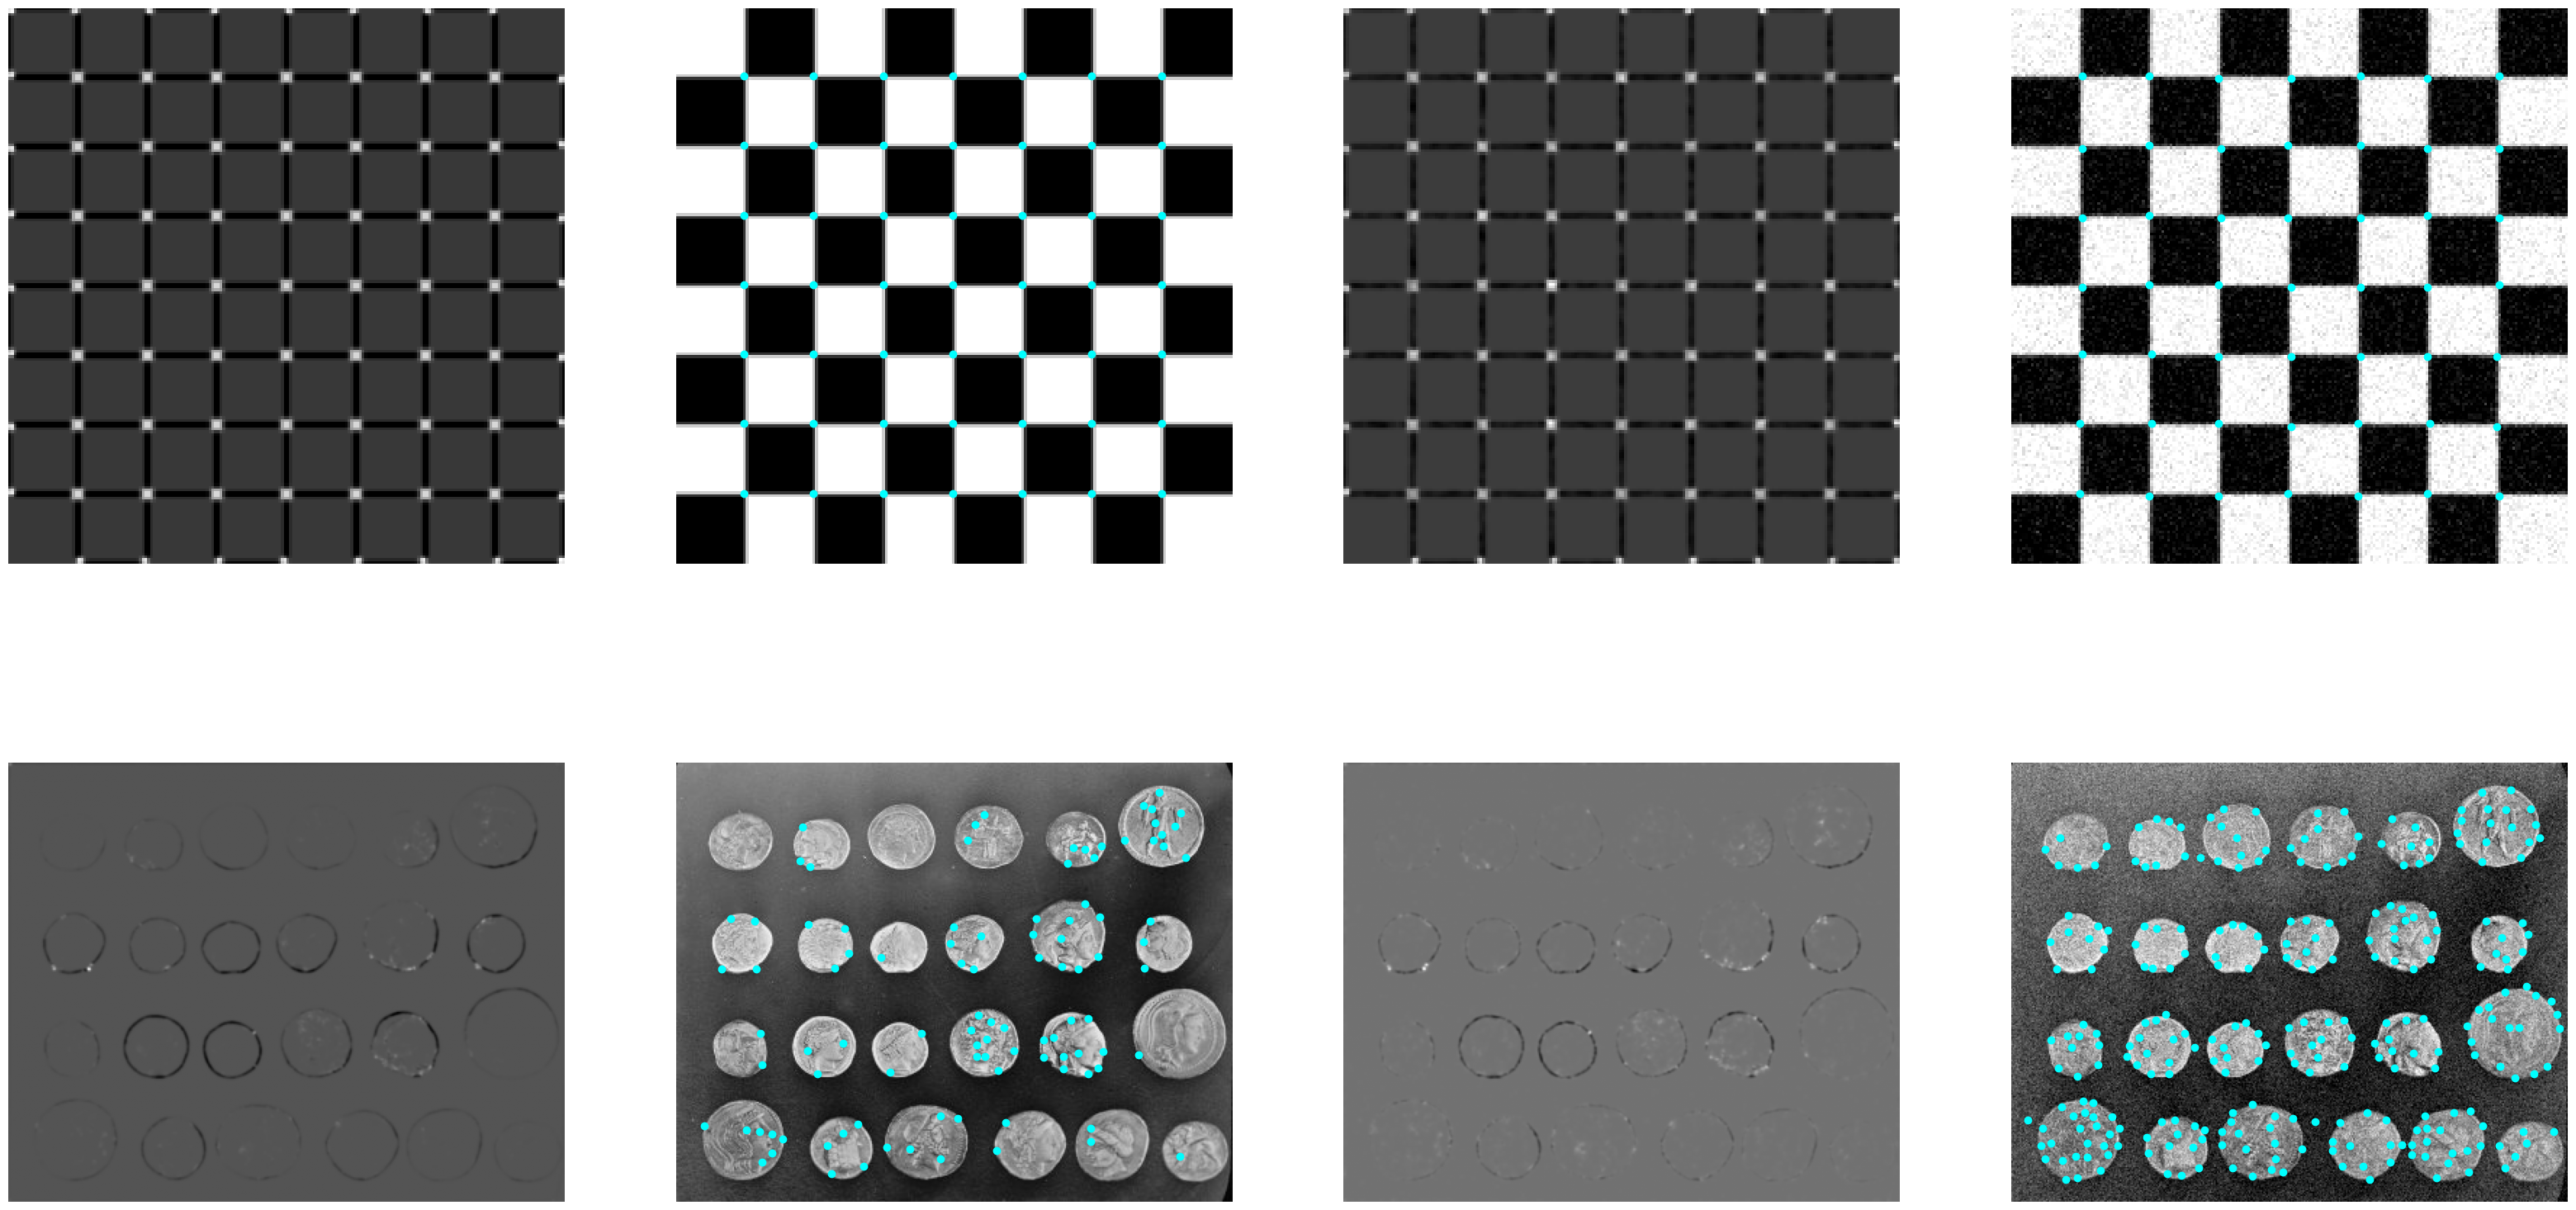

In [30]:
# TODO: Run Harris detector on gray and noisy checkerboard images using skimage
image_checkerboard_gray_harris = feat.corner_harris(image_checkerboard_gray)
image_checkerboard_noisy_harris = feat.corner_harris(image_checkerboard_noisy)

# TODO: Run Harris detector on gray and noisy coin images using skimage
image_coin_gray_harris = feat.corner_harris(image_coin_gray)
image_coin_noisy_harris = feat.corner_harris(image_coin_noisy)

# TODO: Get corner peaks from Harris response maps for gray and noisy checkerboard images using skimage with min_distance of 5 and threshold_rel of 0.02
yx_checkerboard_gray_harris = feat.corner_peaks(image_checkerboard_gray_harris, min_distance=5, threshold_rel=0.02)
yx_checkerboard_noisy_harris = feat.corner_peaks(image_checkerboard_noisy_harris, min_distance=5, threshold_rel=0.02)

# TODO: Get corner peaks from Harris response maps for gray and noisy coin images using skimage with min_distance of 5 and threshold_rel of 0.02
yx_coin_gray_harris = feat.corner_peaks(image_coin_gray_harris, min_distance=5, threshold_rel=0.02)
yx_coin_noisy_harris = feat.corner_peaks(image_coin_noisy_harris, min_distance=5, threshold_rel=0.02)

# Create visualization
fig = plt.figure(figsize=(40, 42))

ax = fig.add_subplot(4, 4, 1)
ax.imshow(image_checkerboard_gray_harris, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 2)
ax.imshow(image_checkerboard_gray, cmap='gray')

# TODO: Plot points from Harris corner for checkerboard
if yx_checkerboard_gray_harris.size > 0:
    ys = yx_checkerboard_gray_harris[:, 0]
    xs = yx_checkerboard_gray_harris[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6) # Refactored plotting style
config_plot()


ax = fig.add_subplot(4, 4, 3)
ax.imshow(image_checkerboard_noisy_harris, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 4)
ax.imshow(image_checkerboard_noisy, cmap='gray')

# TODO: Plot points from Harris corner for noisy checkerboard
if yx_checkerboard_noisy_harris.size > 0:
    ys = yx_checkerboard_noisy_harris[:, 0]
    xs = yx_checkerboard_noisy_harris[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6) # Refactored plotting style
config_plot()


ax = fig.add_subplot(4, 4, 5)
ax.imshow(image_coin_gray_harris, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 6)
ax.imshow(image_coin_gray, cmap='gray')

# TODO: Plot points from Harris corner for coin
if yx_coin_gray_harris.size > 0:
    ys = yx_coin_gray_harris[:, 0]
    xs = yx_coin_gray_harris[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6) # Refactored plotting style
config_plot()


ax = fig.add_subplot(4, 4, 7)
ax.imshow(image_coin_noisy_harris, cmap='gray')
config_plot()

ax = fig.add_subplot(4, 4, 8)
ax.imshow(image_coin_noisy, cmap='gray')

# TODO: Plot points from Harris corner for noisy coin
if yx_coin_noisy_harris.size > 0:
    ys = yx_coin_noisy_harris[:, 0]
    xs = yx_coin_noisy_harris[:, 1]
    ax.plot(xs, ys, color='cyan', marker='o', linestyle='None', markersize=6) # Refactored plotting style
config_plot()


plt.show()